In [4]:
import qiskit as qk
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.options.sampler_options import SamplerOptions
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from pprint import pprint
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# See also https://docs.quantum.ibm.com/guides/primitives-examples 
! pip3 list |grep qiskit
! date

PennyLane-qiskit                  0.39.1
qiskit                            1.2.4
qiskit-aer                        0.15.1
qiskit-ibm-experiment             0.4.8
qiskit-ibm-runtime                0.29.0
qiskit-ionq                       0.5.11
qiskit-machine-learning           0.8.0
Sun Dec  8 12:39:19 PST 2024


In [ ]:
service = QiskitRuntimeService(channel="ibm_quantum")

In [7]:
backends = service.backends()
#print(backends)
for i,backend in enumerate(backends): print(backend,backend.num_qubits)


<IBMBackend('ibm_fez')> 156
<IBMBackend('ibm_marrakesh')> 156
<IBMBackend('ibm_strasbourg')> 127
<IBMBackend('ibm_sherbrooke')> 127
<IBMBackend('ibm_brisbane')> 127
<IBMBackend('ibm_torino')> 133
<IBMBackend('ibm_kyiv')> 127
<IBMBackend('ibm_brussels')> 127


In [8]:
options = SamplerOptions()
options.default_shots=1000

In [9]:
#...!...!....................
def create_ghz_circuit(n):
    qc = qk.QuantumCircuit(n)
    qc.h(0)
    for i in range(1, n):  qc.cx(0, i)
    qc.measure_all()
    return qc
qc=create_ghz_circuit(5)
print(qc)

        ┌───┐                     ░ ┌─┐            
   q_0: ┤ H ├──■────■────■────■───░─┤M├────────────
        └───┘┌─┴─┐  │    │    │   ░ └╥┘┌─┐         
   q_1: ─────┤ X ├──┼────┼────┼───░──╫─┤M├─────────
             └───┘┌─┴─┐  │    │   ░  ║ └╥┘┌─┐      
   q_2: ──────────┤ X ├──┼────┼───░──╫──╫─┤M├──────
                  └───┘┌─┴─┐  │   ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────────┤ X ├──┼───░──╫──╫──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                            └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4 


### A) Run on real HW



In [10]:
# [<IBMBackend('ibm_cusco')>, <IBMBackend('ibm_nazca')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_osaka')>,
# <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_brisbane')>]
#backName='ibm_kyoto'
backName='ibm_kyiv'
#backName='ibm_quebec'
backName='ibm_kyoto'
backend = service.get_backend(backName)

Here we create a pass manager based on the backend and then we run the pass manager on the virtual circuit to create the physical circuit ready to run

In [11]:
# transpiler(..) is now generate_preset_pass_manager(..)
mypass = generate_preset_pass_manager(backend=backend,optimization_level=3, seed_transpiler=44)
qcT = mypass.run(qc)

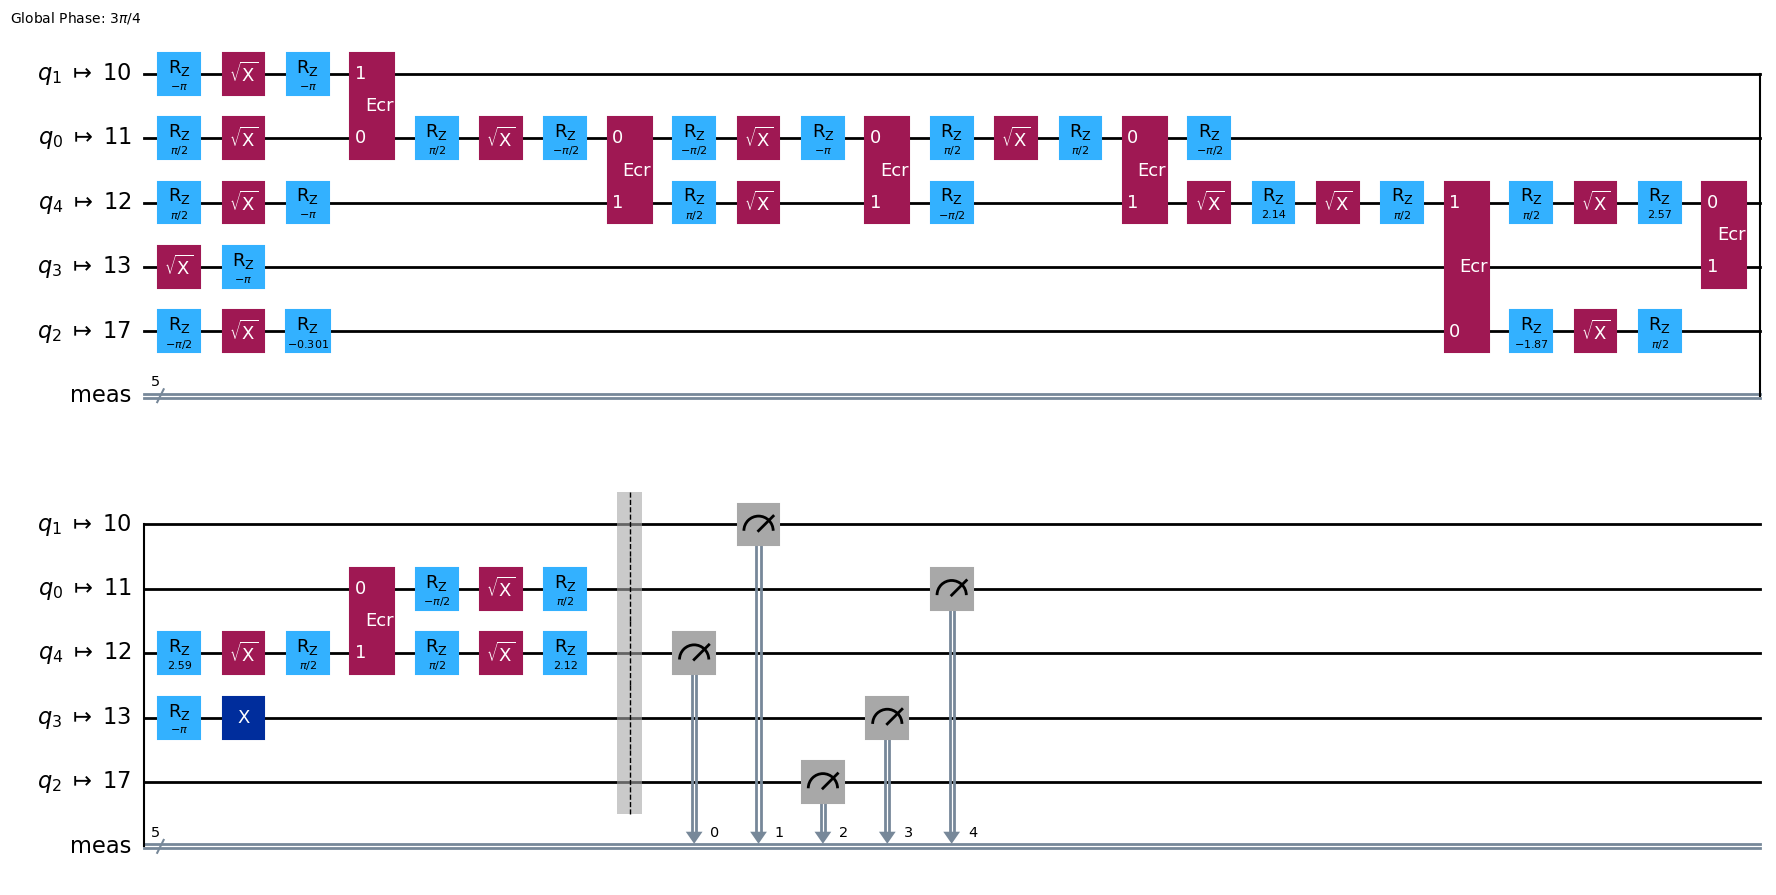

In [12]:
qcT.draw('mpl', idle_wires=False)

In [13]:
#qcT.draw('text', idle_wires=False)

In [ ]:
qcEL=(qcT,)  # quant circ executable list
sampler = Sampler(backend=backend, options=options)
job = sampler.run(qcEL)
result=job.result()

In [ ]:
pprint(result[0].data.meas.get_counts())

### B) Run on fake backend

In [11]:
backName='ibm_torino'
#backName='ibm_kyoto'
noisy_backend = service.backend(backName)
backend2 = AerSimulator.from_backend(noisy_backend)

qcT = qk.transpile(qc, backend=backend2, optimization_level=3)
print('use noisy_backend =', noisy_backend.name )

use noisy_backend = ibm_torino


transpiled CX-depth: 7


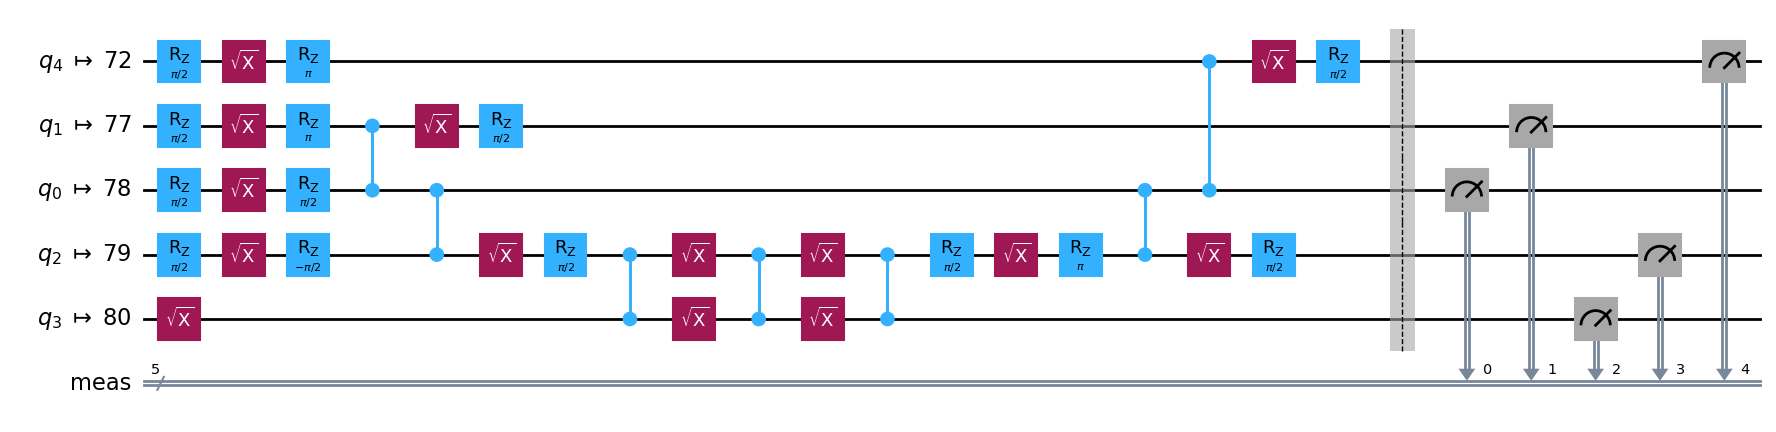

In [12]:
print('transpiled CX-depth:',qcT.depth(filter_function=lambda x: x.operation.num_qubits == 2 ))
#print(qcT.draw(output='text',idle_wires=False)) 
qcT.draw('mpl', idle_wires=False)

In [14]:
print('job started,  nq=%d  at %s ...'%(qcT.num_qubits,backend2.name))
sampler = Sampler(mode=backend2, options=options)
job = sampler.run([qcT])
result=job.result()
jobMD=result.metadata    

job started,  nq=133  at aer_simulator_from(ibm_torino) ...


In [15]:
pprint(result[0].data.meas.get_counts())

{'00000': 32,
 '00001': 34,
 '00010': 33,
 '00011': 36,
 '00100': 34,
 '00101': 33,
 '00110': 35,
 '00111': 36,
 '01000': 26,
 '01001': 35,
 '01010': 24,
 '01011': 33,
 '01100': 18,
 '01101': 31,
 '01110': 33,
 '01111': 35,
 '10000': 29,
 '10001': 31,
 '10010': 41,
 '10011': 31,
 '10100': 39,
 '10101': 37,
 '10110': 37,
 '10111': 26,
 '11000': 33,
 '11001': 21,
 '11010': 30,
 '11011': 32,
 '11100': 29,
 '11101': 21,
 '11110': 26,
 '11111': 29}


C) Run on ideal backend

In [ ]:
backend3 = AerSimulator()
print('job started,  nq=%d  at %s ...'%(qcT.num_qubits,backend3.name))
sampler = Sampler(backend=backend3, options=options)
qcT = qk.transpile(qc, backend=backend3, optimization_level=3)
job = sampler.run([qcT])
result=job.result()
pprint(result[0].data.meas.get_counts())

In [ ]:
print(qc)